In [194]:
from pharynx_analysis import (pharynx_io as pio, image_processing as ip, experiment, plots)
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from importlib import reload
from skimage import measure, transform
from collections import namedtuple
import pdb

In [204]:
reload(pio);
reload(ip);
reload(experiment);

In [205]:
img_path = "/Users/sean/code/wormAnalysis/data/paired_ratio_movement_data_sean/2017_02_22-HD233_SAY47/2017_02_22-HD233_SAY47.tif"
strain_map_path = "/Users/sean/code/wormAnalysis/data/paired_ratio_movement_data_sean/2017_02_22-HD233_SAY47/indexer.csv"
strains = pio.load_strain_map_from_disk(strain_map_path)

In [206]:
ex = experiment.PairExperiment(img_path, "TL/470/410/470/410", strains)

/Users/sean/.local/share/virtualenvs/python-zUhjj0fC/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


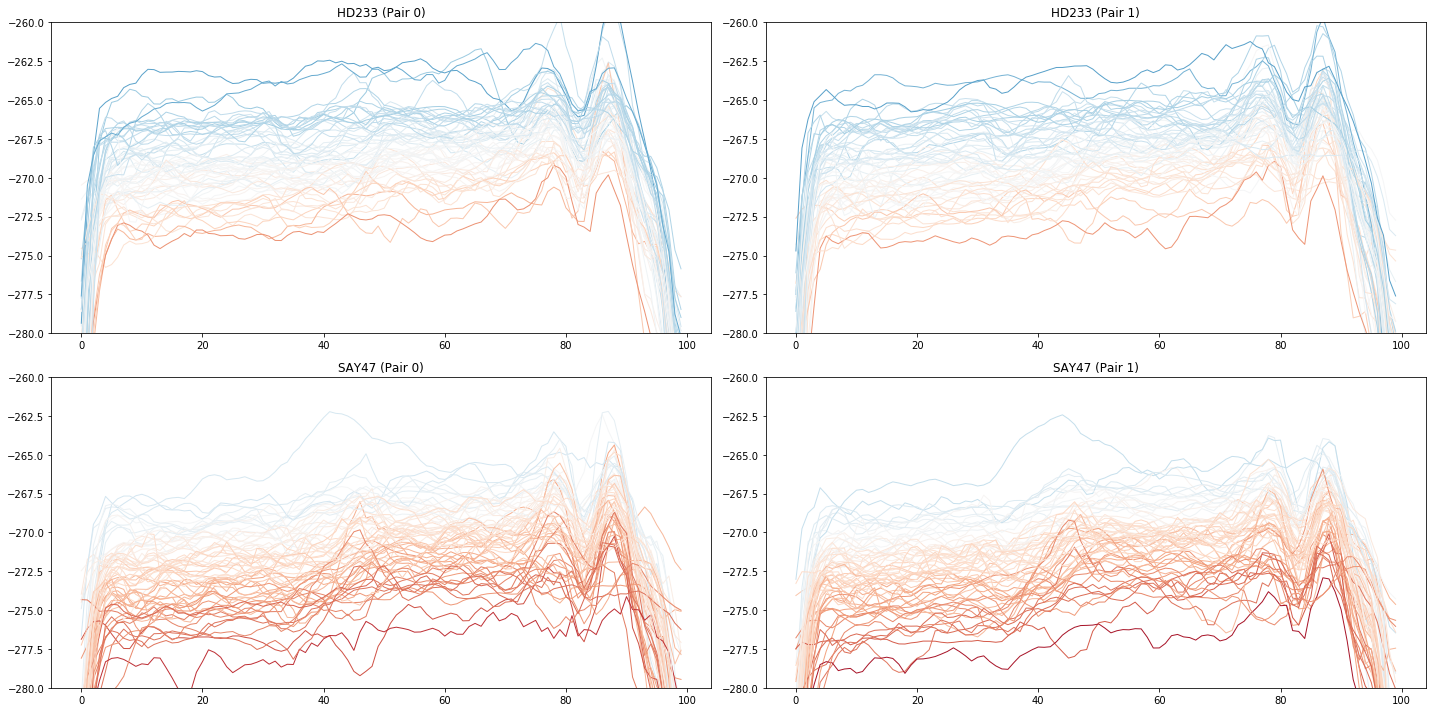

In [208]:
plots.plot_individual_profile_data_by_strain_and_pair(
    ex.e, cmin=-280, cmax=-260, cmap_name='RdBu',
    ylim=[-280, -260], figsize=(20,10)
)